In [64]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

# from sklearn import metrics
# from sklearn.preprocessing import StandardScaler
# from scipy.stats import norm
# import statsmodels.api as sm
%matplotlib inline

### Get VTI history

In [2]:
vti = yf.Ticker("VTI")
vti_hist = vti.history(period="max")

#### Get top 10 holding in VTI


##### * Top 10 holdings were NOT found programatically. This info has yet to be found in the vti object *

In [3]:
microsoft = yf.Ticker('MSFT')
apple = yf.Ticker('AAPL')
amazon = yf.Ticker('AMZN')
facebook = yf.Ticker('FB')
alphabetA = yf.Ticker('GOOGL')
alphabetC = yf.Ticker('GOOG')
johnson = yf.Ticker('JNJ')
berkshire = yf.Ticker('BRK.B')
visa = yf.Ticker('V')
proctor = yf.Ticker('PG')

In [4]:
vti_holdings = [microsoft,apple,amazon,facebook,alphabetA,alphabetC,johnson,berkshire,visa,proctor]

#### Get DOW

In [6]:
dow = yf.Ticker('DJIA')

#### Visualy look for trends

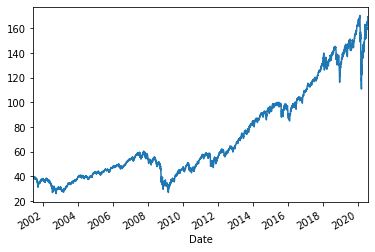

In [12]:
vti_hist.Close.plot()

#### test for stationarity

In [19]:
dfuller_results = adfuller(vti_hist.Close)

In [22]:
pd.Series(dfuller_results[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                    1.170725
p-value                           0.995777
#Lags Used                       27.000000
Number of Observations Used    4789.000000
dtype: float64

In [25]:
vti_diff = vti_hist.diff()

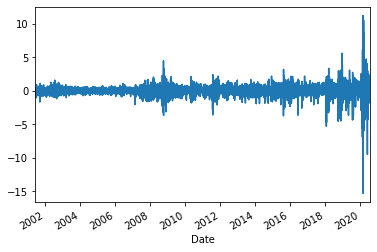

In [30]:
vti_diff.Close.plot()

In [28]:
dfuller_results = adfuller(vti_diff[1::].Close)

In [29]:
pd.Series(dfuller_results[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                -1.440617e+01
p-value                        8.350659e-27
#Lags Used                     2.600000e+01
Number of Observations Used    4.789000e+03
dtype: float64

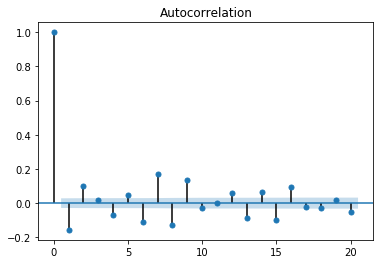

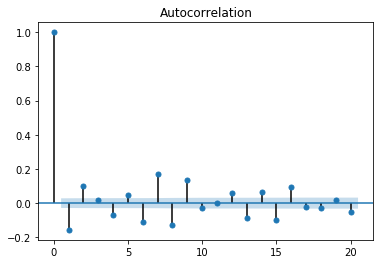

In [63]:
plot_acf(vti_diff[1::].Close, alpha=.05, lags=20)

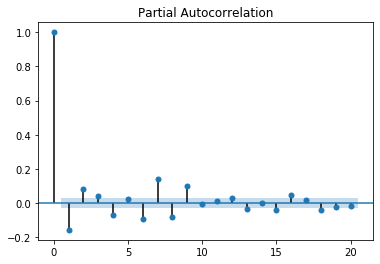

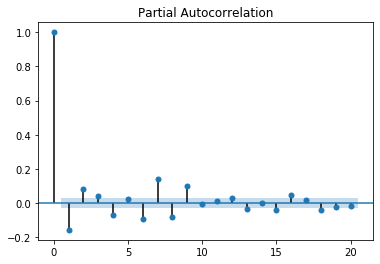

In [62]:
plot_pacf(vti_diff[1::].Close, alpha=.05, lags=20)

In [66]:
arimodel = ARIMA(vti_diff[1::].Close, order=(4,1,2))
model_fit = arimodel.fit(disp=0)
print(model_fit.summary())

/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4815
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -6422.807
Method:                       css-mle   S.D. of innovations              0.918
Date:                Fri, 07 Aug 2020   AIC                          12861.614
Time:                        17:53:04   BIC                          12913.450
Sample:                             1   HQIC                         12879.817
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.664e-05   8.98e-06      1.853      0.064   -9.63e-07    3.42e-05
ar.L1.D.Close    -0.9435      0.026    -36.143      0.000      -0.995      -0.892
ar.L2.D.Close    -0.0239      0.020     

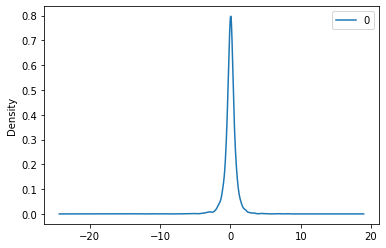

In [69]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')

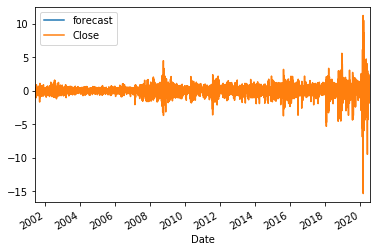

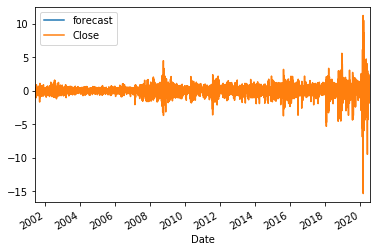

In [70]:
model_fit.plot_predict()

In [77]:
model_fit.forecast()

3